In [21]:
from dataset import Edinb_SE_Dataset, make_loader
import matplotlib.pyplot as plt
from utils.hparams import HParam
from model.coherence_net.model import CoherenceNet
import torch
import numpy as np

def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.int64)

def apply_selection(conv_wt_pt, embedding):
    out_embedding = torch.zeros(embedding.shape)
    weight = conv_wt_pt #torch.load(conv_wt_pt)
    for i in range(0, 512):
        k = weight[:, i:i+1, :, :]
        e = embedding[:, i:i+1, :, :]
        out_embedding[:, i:i+1, :, :] = torch.nn.functional.conv2d(e, k, padding="same")
    return out_embedding

#log_space = gen_log_space(1025, 128)

import numpy as np

def normalized_euclidean_distance(spec1, spec2):
    """
    Compute the normalized Euclidean distance between two spectrograms.
    
    Parameters:
        spec1 (np.array): First spectrogram (2D array of shape [time, frequency]).
        spec2 (np.array): Second spectrogram (2D array of shape [time, frequency]).
        
    Returns:
        float: Normalized Euclidean distance between spec1 and spec2.
    """
    # Compute the Euclidean distance
    distance = np.linalg.norm(spec1 - spec2)
    
    # Normalization - Assuming the range of values in spectrogram is from 0 to 1
    max_possible_distance = np.sqrt((1 - 0)**2 * spec1.size)
    
    # Normalize the distance
    normalized_distance = distance / max_possible_distance
    
    return 1 - normalized_distance

from skimage.metrics import structural_similarity as ssim

def calculate_ssim_index(spectrogram1, spectrogram2):
    # Calculate Structural Similarity Index (SSIM)
    return ssim(spectrogram1, spectrogram2, data_range=spectrogram2.max() - spectrogram2.min())

import numpy as np
from sklearn.metrics import normalized_mutual_info_score

def calculate_nmi(spec1, spec2):
    """
    Calculate the Normalized Mutual Information (NMI) between two spectrograms.
    
    Parameters:
        spec1 (np.array): First spectrogram (2D array of shape [time, frequency]).
        spec2 (np.array): Second spectrogram (2D array of shape [time, frequency]).
        
    Returns:
        float: NMI index between the two spectrograms.
    """
    # Flatten the spectrograms to 1D arrays for NMI calculation
    spec1_flat = spec1.flatten()
    spec2_flat = spec2.flatten()
    
    # Compute NMI
    nmi_value = normalized_mutual_info_score(spec1_flat, spec2_flat)
    
    return nmi_value

import numpy as np
from scipy.spatial.distance import cosine

def calculate_cosine_similarity(spec1, spec2):
    """
    Calculate the cosine similarity between two spectrograms.
    
    Parameters:
        spec1 (np.array): First spectrogram (2D array of shape [time, frequency]).
        spec2 (np.array): Second spectrogram (2D array of shape [time, frequency]).
        
    Returns:
        float: Cosine similarity between the two spectrograms.
    """
    # Flatten the spectrograms to 1D arrays
    spec1_flat = spec1.flatten()
    spec2_flat = spec2.flatten()
    
    # Compute cosine similarity, which is defined as 1 minus the cosine distance
    cosine_sim = 1 - cosine(spec1_flat, spec2_flat)
    
    return cosine_sim

from scipy.stats import entropy
def calculate_kl_divergence(spectrogram1, spectrogram2):
    # Calculate KL Divergence
    # Normalize spectrograms to sum to 1
    prob1 = spectrogram1.flatten() / np.sum(spectrogram1)
    prob2 = spectrogram2.flatten() / np.sum(spectrogram2)
    return entropy(prob1, prob2)



# Example spectrograms
spec1 = np.random.rand(100, 256)  # Simulate a spectrogram with 100 time steps and 256 frequency bins
spec2 = np.random.rand(100, 256)  # Another random spectrogram of the same size

# Calculate Cosine Similarity
cosine_similarity = calculate_cosine_similarity(spec1, spec2)
print(f"Cosine Similarity: {cosine_similarity:.3f}")


# Example spectrograms
#spec1 = np.random.rand(100, 256)  # Simulate a 100 time steps and 256 frequency bins spectrogram
#spec2 = np.random.rand(100, 256)  # Another random spectrogram of the same size

# Calculate the normalized Euclidean distance
#distance = normalized_euclidean_distance(spec1, spec2)
#print(f"Normalized Euclidean Distance: {distance:.3f}")


config = HParam("config-128.yaml")
model = CoherenceNet(config.Coherence_Net_Config.layer1, config.Coherence_Net_Config.layer2)
model = model.lay1.stream2
checkpoint = torch.load(config.SE_Config.lay1_stream2_bestchkpt_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)

Cosine Similarity: 0.750


<All keys matched successfully>

Dataset Length: 100
loader complete


0it [00:00, ?it/s]

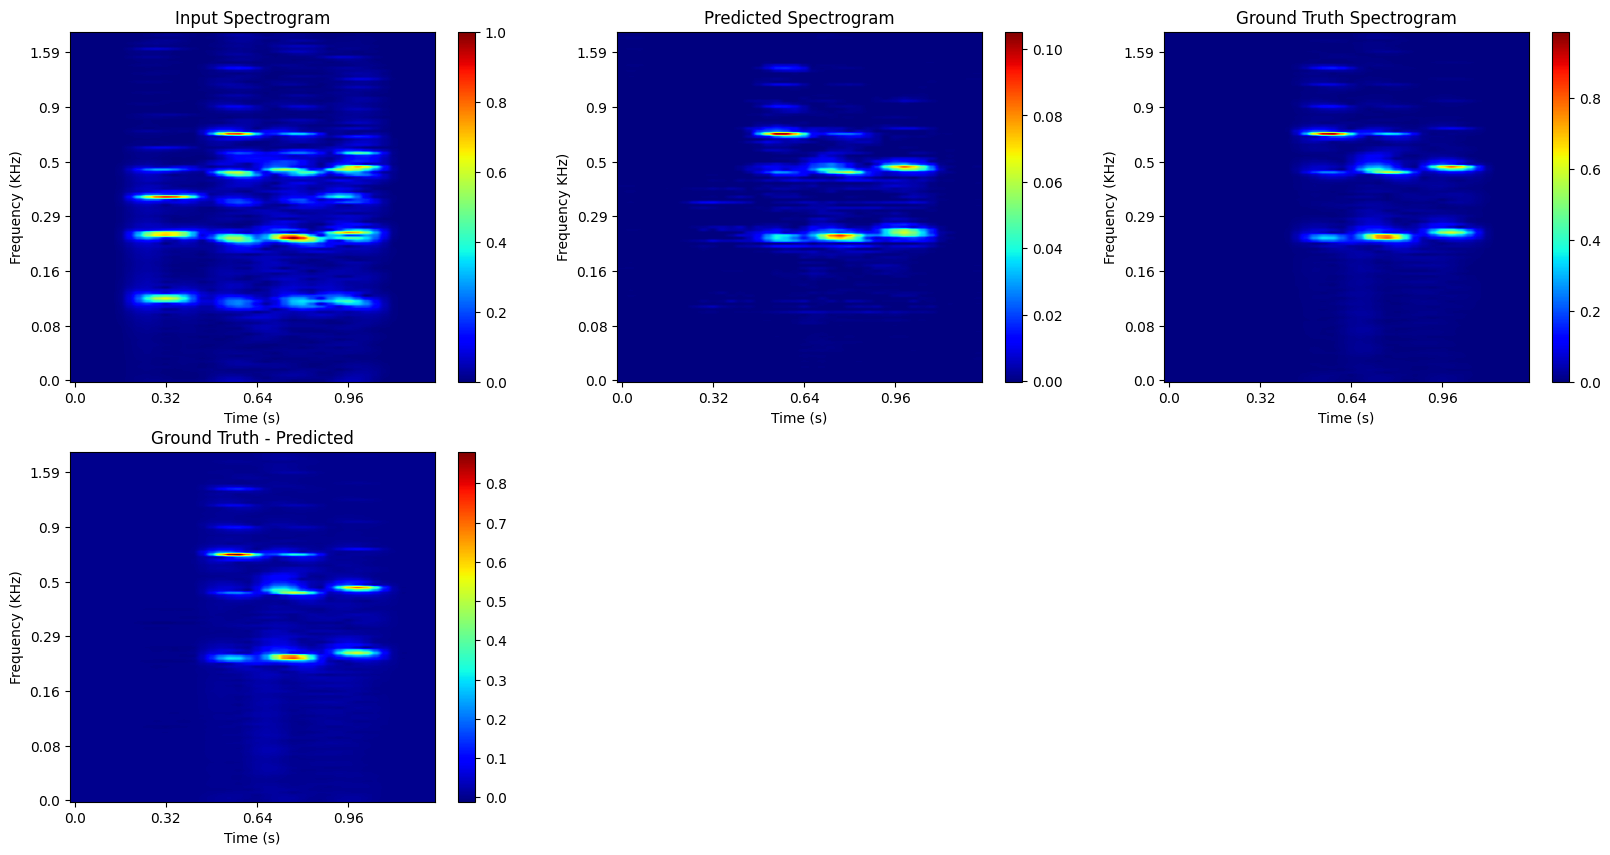

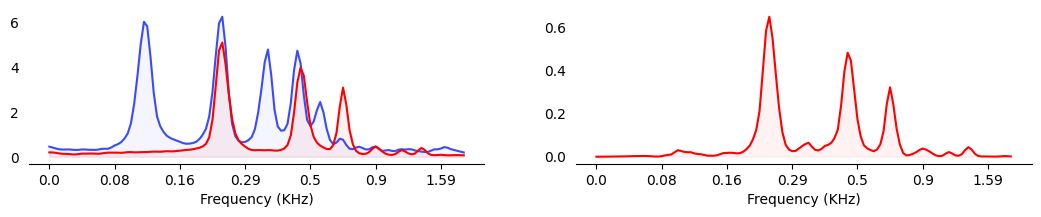

3it [00:01,  2.27it/s]

100it [00:27,  3.66it/s]


0.6108872933687531
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

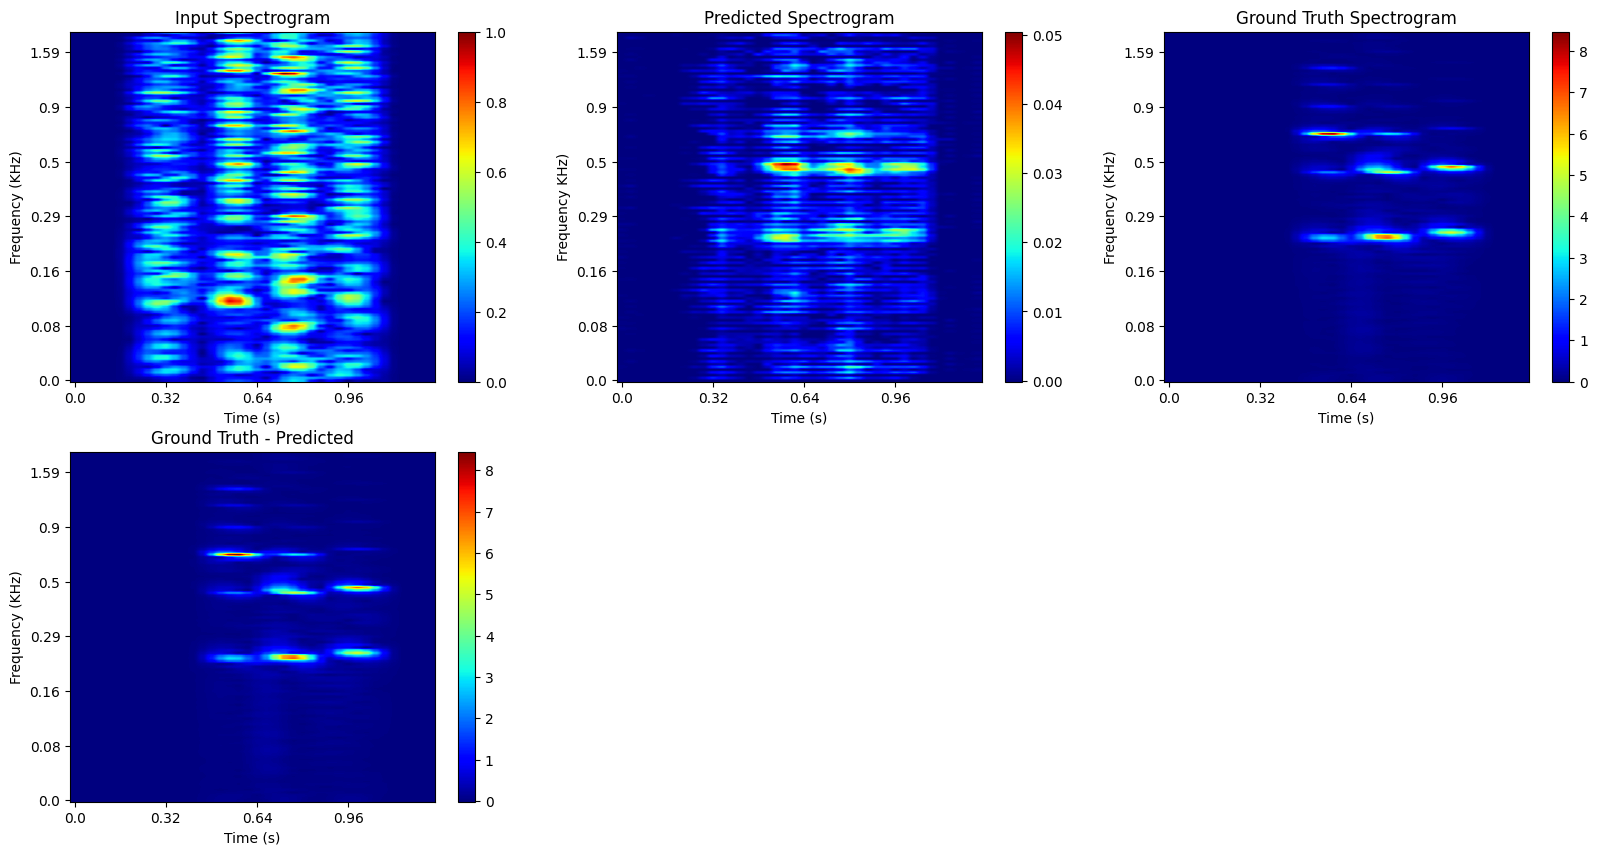

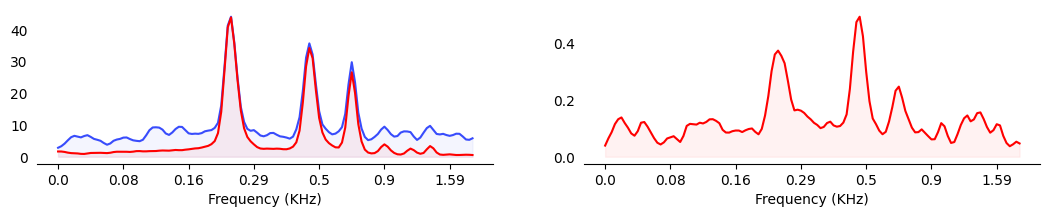

100it [00:27,  3.57it/s]

0.5837458510742048


In [20]:
from dataset import gen_log_space
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d


def get_scores(noisy_files_path):

    config = HParam("config-128.yaml")
    model = CoherenceNet(config.Coherence_Net_Config.layer1, config.Coherence_Net_Config.layer2)
    model = model.lay1.stream2
    checkpoint = torch.load(config.SE_Config.lay1_stream2_bestchkpt_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint)

    # Adjust these paths and parameters
    clean_files_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/female_alone_random"  #shifted_   sftp://10.160.200.29/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/1_mixture_random/mti_mni_mfa_mne-p80-ffa_fti_fbe.wav
    #noisy_files_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.2/"   #male_alone_random"  #shifted_
    batch_size = 1
    model_type = "coherence_net"
    #save_path = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/shifted_male_in_male_attention_random_conv/"
    female_attn = True
    u = 0
    scores = []
    log_space = gen_log_space(500, 128)

    model = model.to("cuda")

    import numpy as np

    # Instantiate the dataset
    dataset = Edinb_SE_Dataset(clean_files_path, noisy_files_path, pad = True)
                        
    print(f"Dataset Length: {len(dataset)}")

    # Instantiate the DataLoader
    loader = torch.utils.data.DataLoader(dataset= dataset,
                                                batch_size= 1,
                                                shuffle=False,
                                                collate_fn = dataset.collate_batch_coherence_net,
                                                pin_memory=True,
                                                num_workers=0)

    print("loader complete")

    # Iterate over the DataLoader
    for i, (input_spec, output_spec, indicator, phase_mixed, raw_wavs_target, speaker_ids) in tqdm(enumerate(loader)):
        # For now, just print the shape of the loaded data
        #print(speaker_ids[0][6:])

        if female_attn:
            input_spec = input_spec[1:2]
            indicator = indicator[1:2]
        else:
            input_spec = input_spec[0:1]
            indicator = indicator[0:1]

        #input_spec = torch.ones_like(input_spec)

        # ouput from the model
        model_pred, model_pred_before, model_pred_after = model(input_spec.to("cuda"), indicator.to("cuda"))

        model_pred_after = apply_selection(model.conv_final[0].weight, model_pred_after)

        model_pred = model_pred.to("cpu")
        model_pred_before = model_pred_before.to("cpu")
        model_pred_after = model_pred_after.to("cpu")

        score = calculate_kl_divergence(model_pred[0, 0].detach().to("cpu").numpy(), output_spec[1, 0].detach().to("cpu").numpy()) #torch.nn.functional.mse_loss(model_pred[0, 0], output_spec[1, 0])
        scores.append(score.item())

        #print(model_pred[0, 0].min(), model_pred[0, 0].max(), output_spec[1, 0].min(), output_spec[1, 0].max())
        
        if u < 1:
            #print(score)

            #print(input_spec.shape, "The shape of the input spec")
            #print(indicator.shape, "The shape of the indicator")
            #print(indicator)

            plt.figure(figsize=(20, 10))
            
            #print(speaker_ids)

            #time_axis = np.arange(0, 40) * 256/16000
            # Visualizing the spectrogram of the first item in the batch
            plt.subplot(2, 3, 1)
            plt.imshow(input_spec[0, 0].numpy(), aspect='auto', origin='lower', cmap='jet')
            plt.colorbar()
            plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
            plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Time (s)")
            plt.ylabel("Frequency (KHz)")
            plt.title("Input Spectrogram")
            
            plt.subplot(2, 3, 2)
            plt.imshow(model_pred[0, 0].detach().numpy(), aspect='auto', origin='lower', cmap='jet')
            plt.colorbar()
            plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
            plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Time (s)")
            plt.ylabel("Frequency KHz)")
            plt.title("Predicted Spectrogram")

            plt.subplot(2, 3, 3)
            plt.imshow(output_spec[1, 0].numpy(), aspect='auto', origin='lower', cmap='jet')
            plt.colorbar()
            plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
            plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Time (s)")
            plt.ylabel("Frequency (KHz)")
            plt.title("Ground Truth Spectrogram")

            plt.subplot(2, 3, 4)
            plt.imshow(output_spec[1, 0].numpy() - model_pred[0, 0].detach().numpy(), aspect='auto', origin='lower', cmap='jet')
            plt.colorbar()
            plt.xticks([i for i in range(0, 40, 10)], [i*(512/16000) for i in range(0, 40, 10)])
            plt.yticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Time (s)")
            plt.ylabel("Frequency (KHz)")
            plt.title("Ground Truth - Predicted")

            #plt.savefig(save_path + "spectrogram_" + speaker_ids[0][6:] + ".png", dpi =300)

            male = output_spec[0, 0].numpy().sum(axis=1)
            female = output_spec[1, 0].numpy().sum(axis=1)

            predicted = model_pred[0, 0].detach().numpy().sum(axis=1)

            plt.figure(figsize=(20, 2))
            plt.subplot(1, 3, 1)

            # Applying Gaussian filter for smoothing
            sigma = 1

            smoothed_male = gaussian_filter1d(male, sigma)
            smoothed_female = gaussian_filter1d(female, sigma)

            # Plotting the smoothed data
            plt.plot(smoothed_male, color='#384CFC', label='Male')
            plt.plot(smoothed_female, color='#FF0000', label='Female')
            plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
            plt.xlabel("Frequency (KHz)")

            # Shading the area below the smoothed lines
            plt.fill_between(range(len(smoothed_male)), smoothed_male, color='#384CFC', alpha=0.05)
            plt.fill_between(range(len(smoothed_female)), smoothed_female, color='#FF0000', alpha=0.05)

            # Removing the top, right, and left borders
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)

            # Only keeping the x-axis
            plt.gca().spines['bottom'].set_color('black')
            plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

            plt.subplot(1, 3, 2)

            # Applying Gaussian filter for smoothing to predicted data
            smoothed_predicted = gaussian_filter1d(predicted, sigma)

            # Plotting the smoothed data
            if female_attn == False:
                plt.plot(smoothed_predicted, color='#384CFC', label='Predicted')
                plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
                plt.xlabel("Frequency (KHz)")

                # Shading the area below the smoothed lines
                plt.fill_between(range(len(smoothed_predicted)), smoothed_predicted, color='#384CFC', alpha=0.05)
            
            elif female_attn == True:
                plt.plot(smoothed_predicted, color='#FF0000', label='Predicted')
                plt.xticks([i for i in range(0, 128, 20)], [round(log_space[i]*(8000/2048)/1000, 2) for i in range(0, 128, 20)])
                plt.xlabel("Frequency (KHz)")

                # Shading the area below the smoothed lines
                plt.fill_between(range(len(smoothed_predicted)), smoothed_predicted, color='#FF0000', alpha=0.05)

            # Removing the top, right, and left borders
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)

            # Only keeping the x-axis
            plt.gca().spines['bottom'].set_color('black')
            plt.gca().tick_params(axis='y', which='both', left=False)  # Remove y-axis ticks

            plt.show()
        u += 1
    return scores

score = get_scores("/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0/")  
print(np.mean(score))
score = get_scores("/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_1.0/") 
print(np.mean(score))

In [3]:
np.mean(score)

0.5668901675939559

In [16]:
np.mean(score)

0.4778272302730816

/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

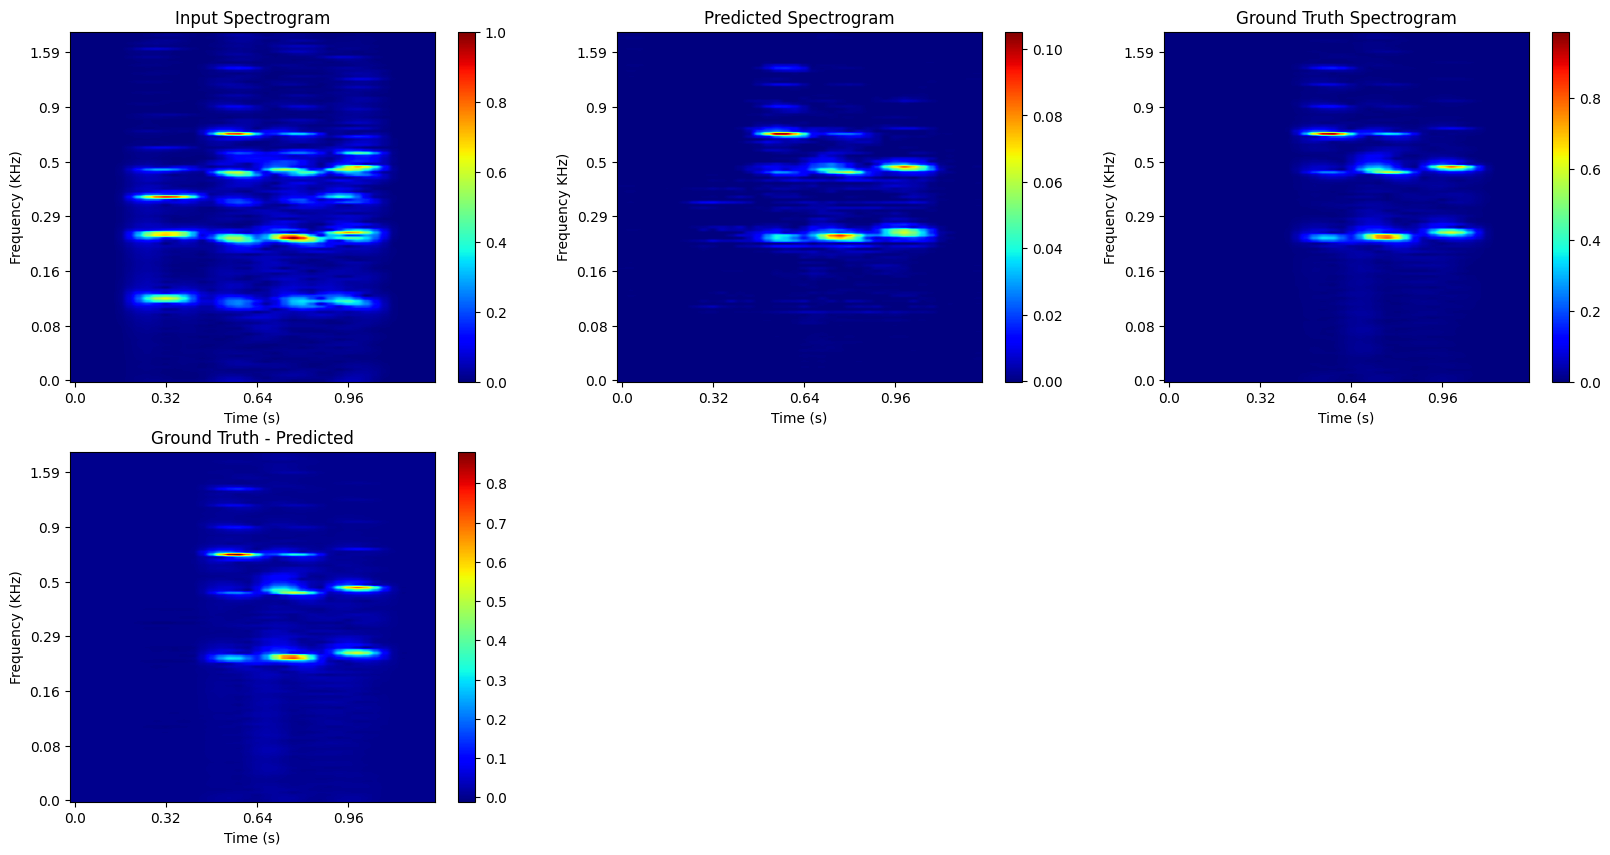

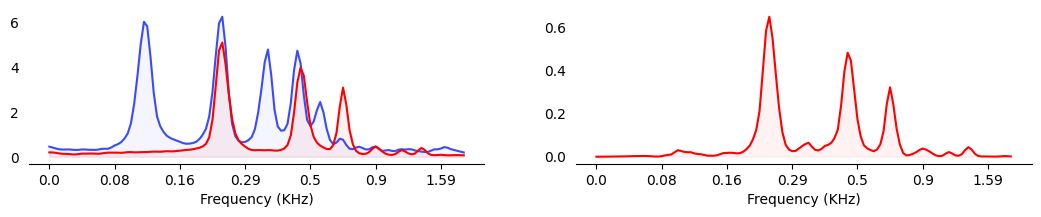

100it [00:27,  3.63it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.1
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

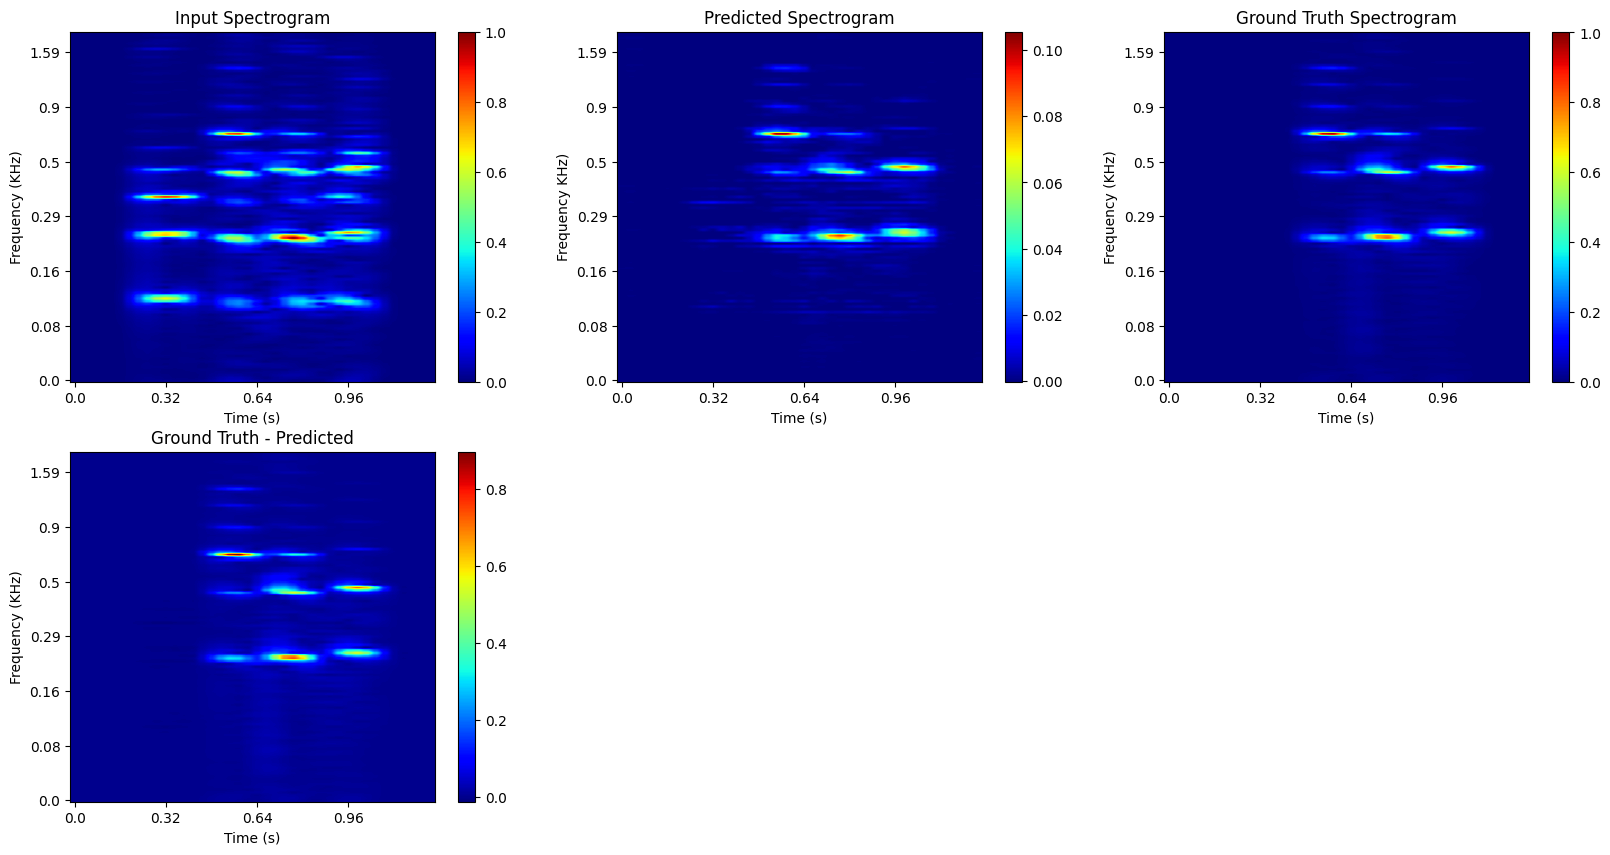

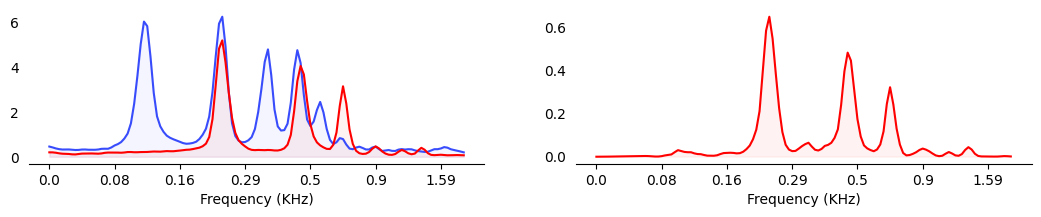

100it [00:28,  3.53it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.2
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

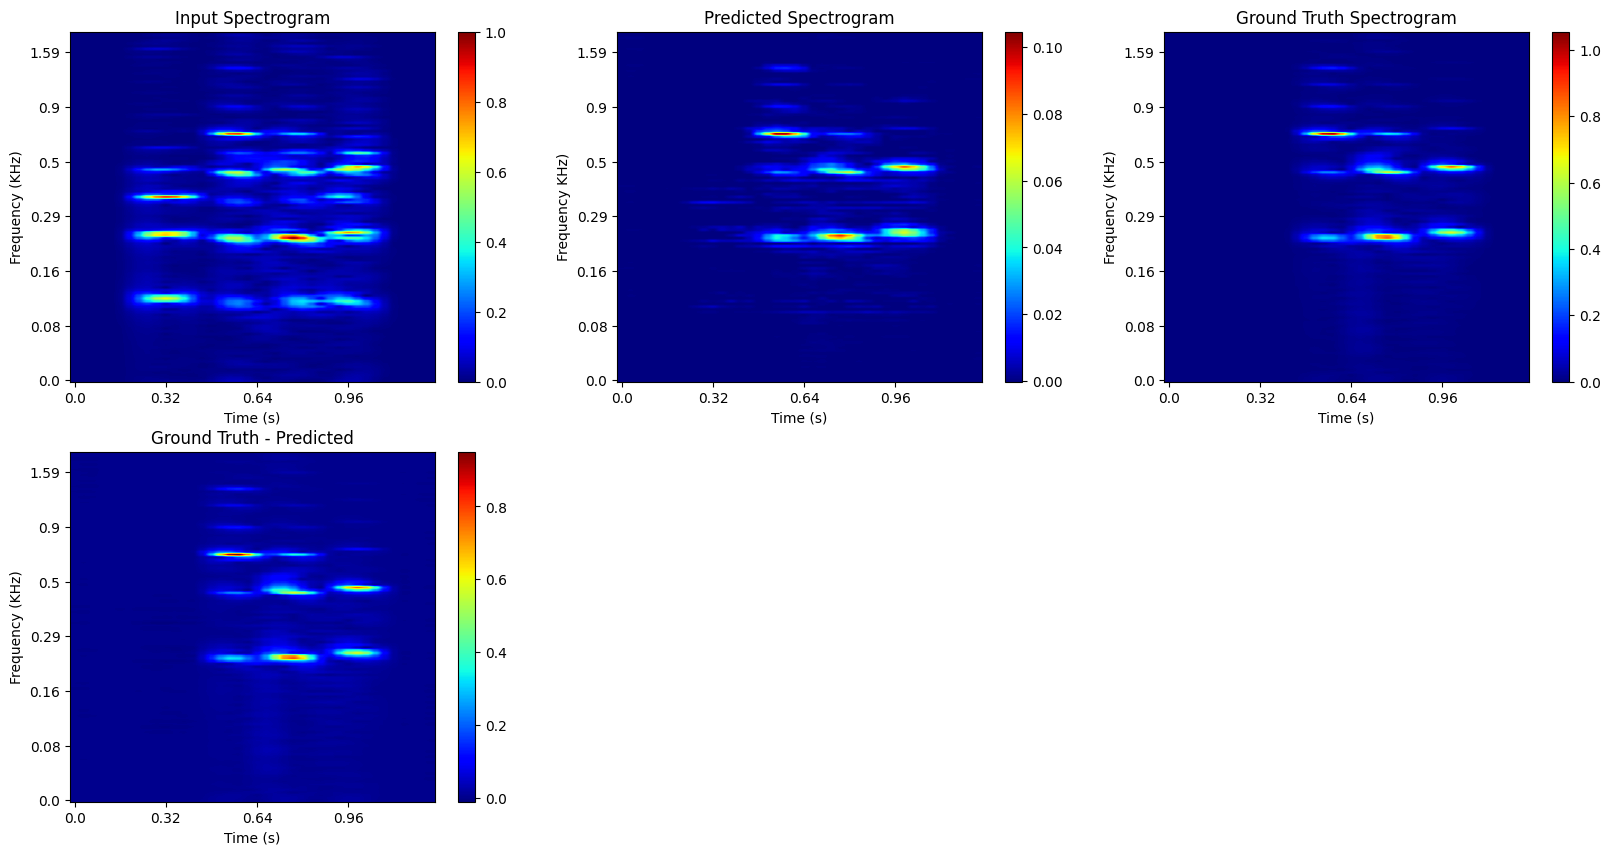

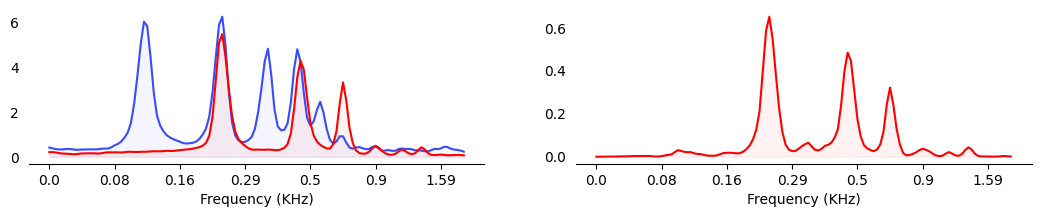

100it [00:29,  3.41it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.3
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

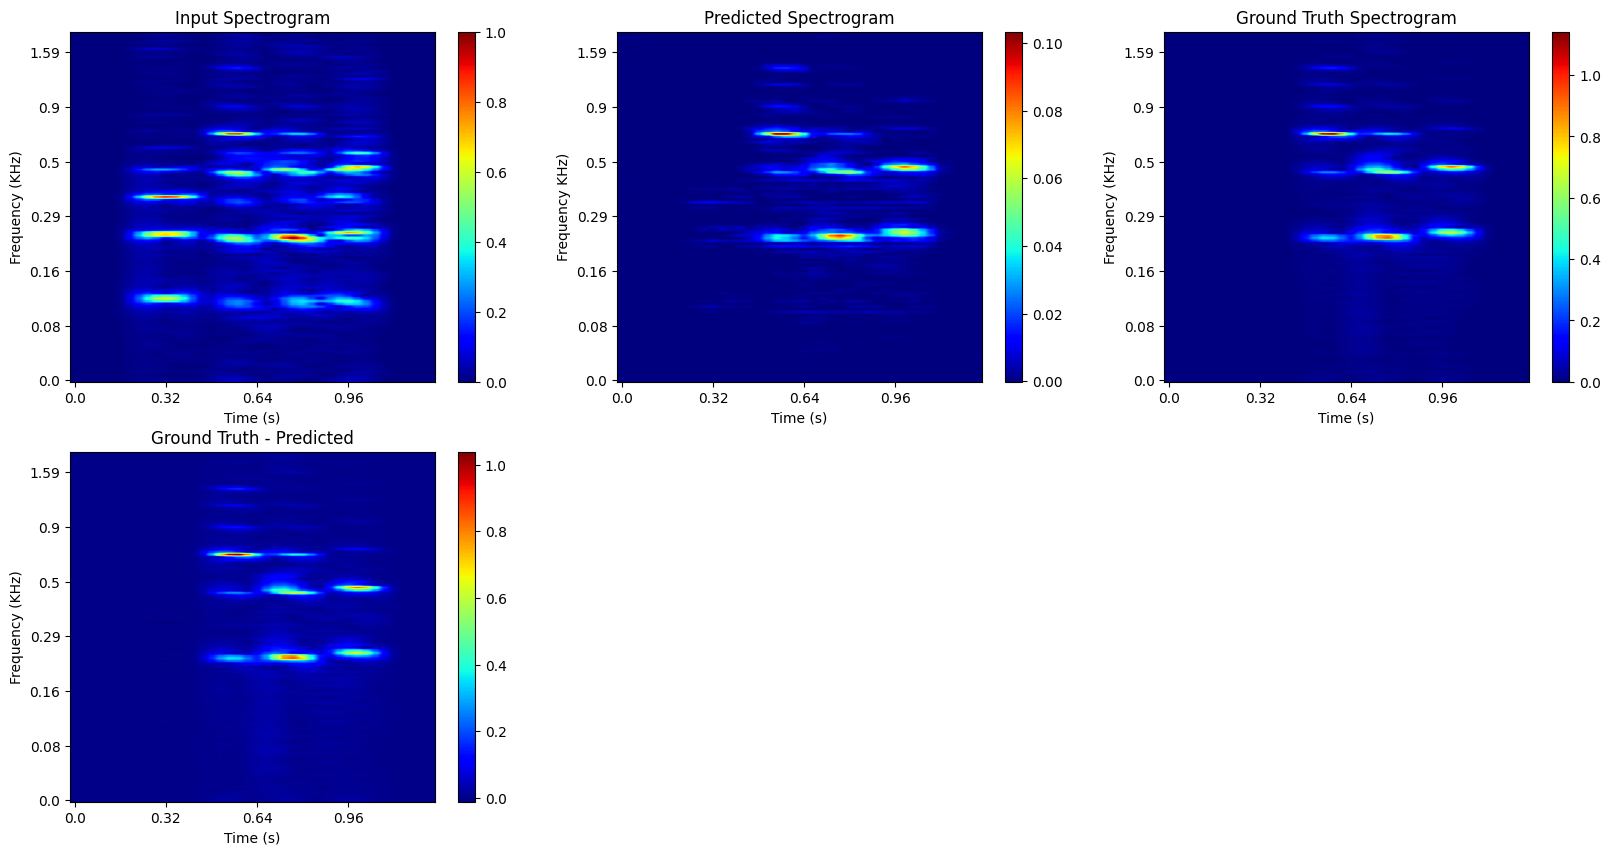

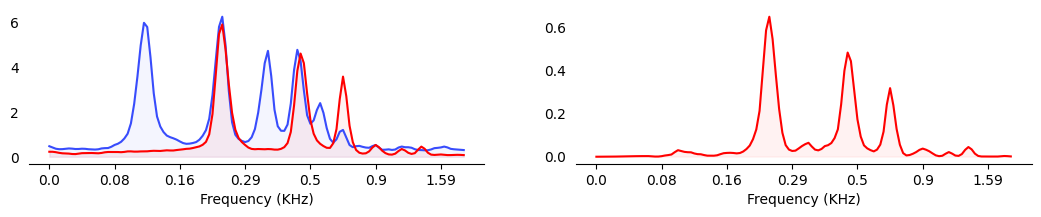

100it [00:28,  3.48it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.4
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

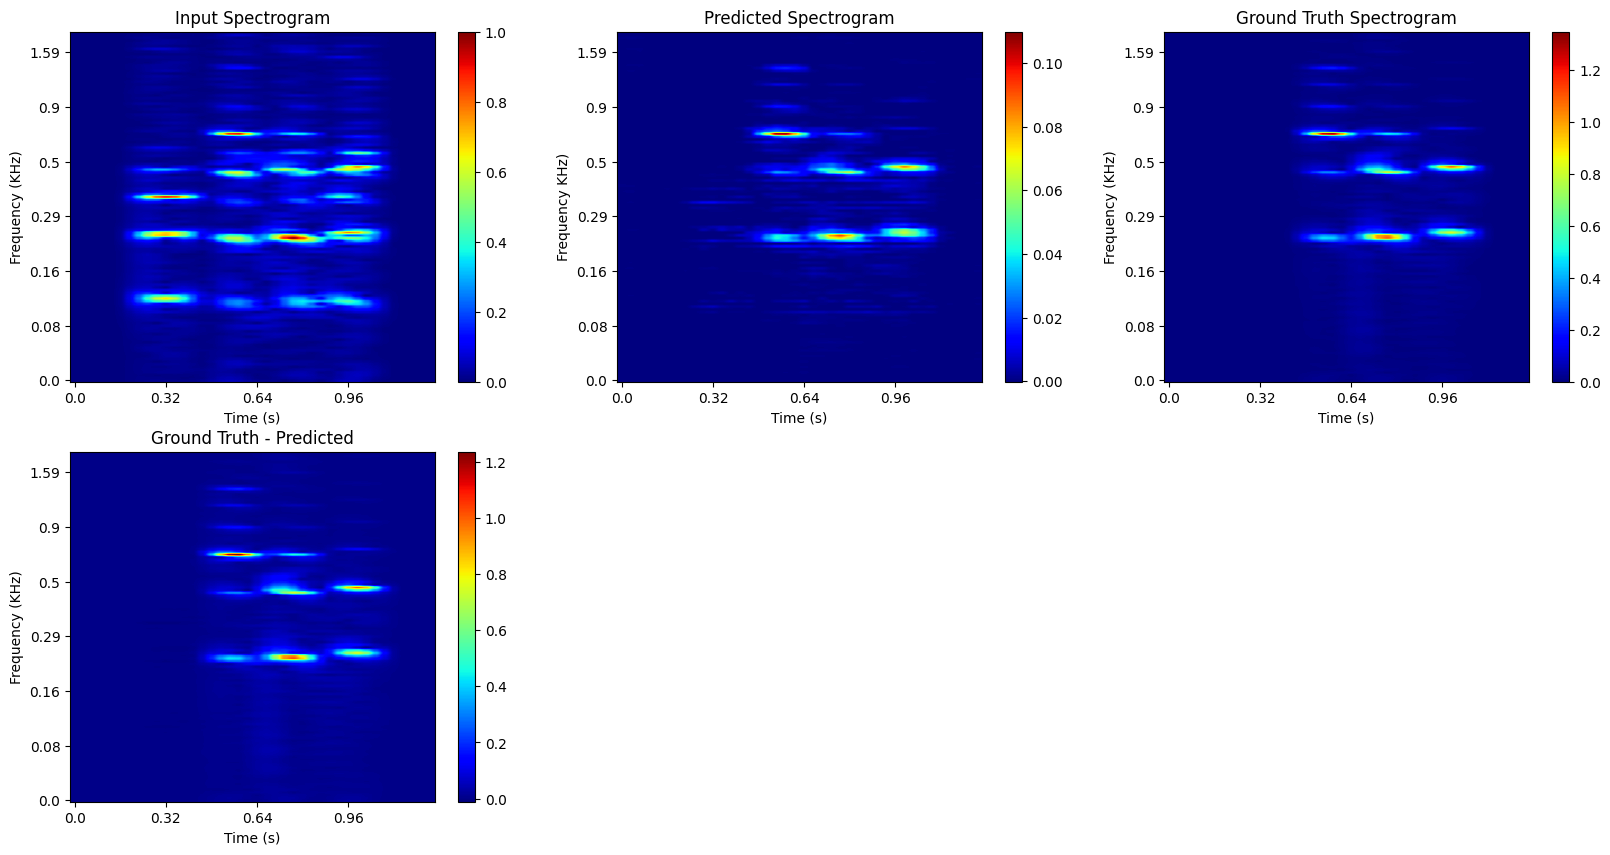

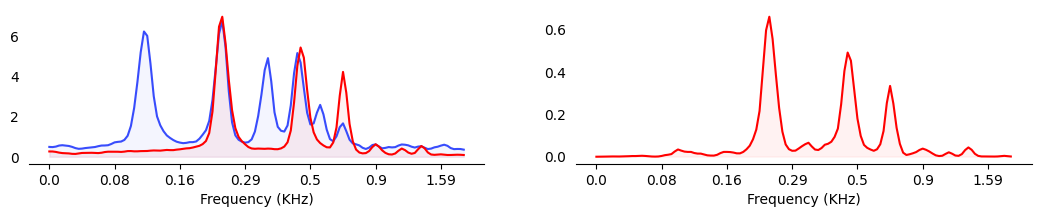

100it [00:27,  3.64it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.5
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

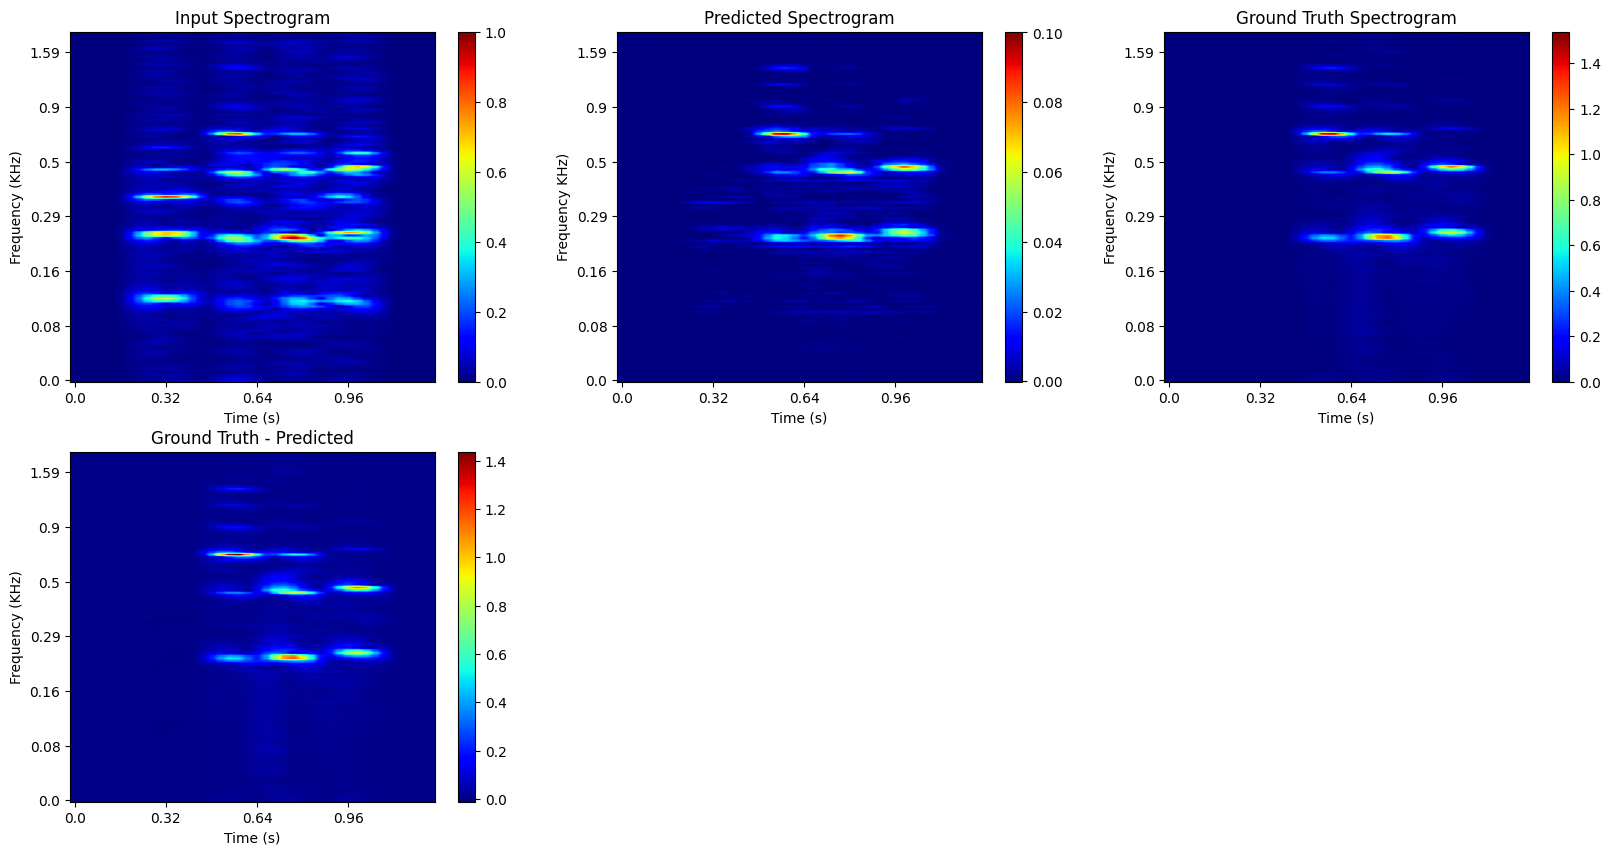

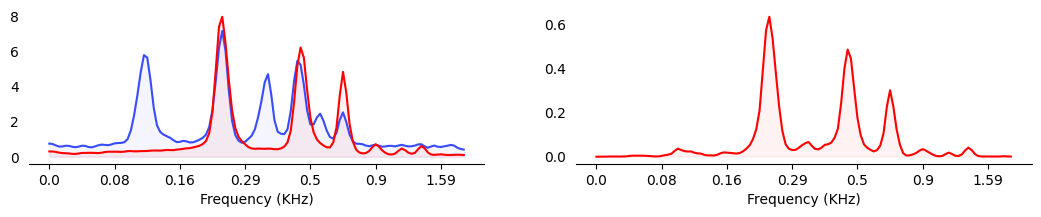

100it [00:28,  3.46it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.6
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

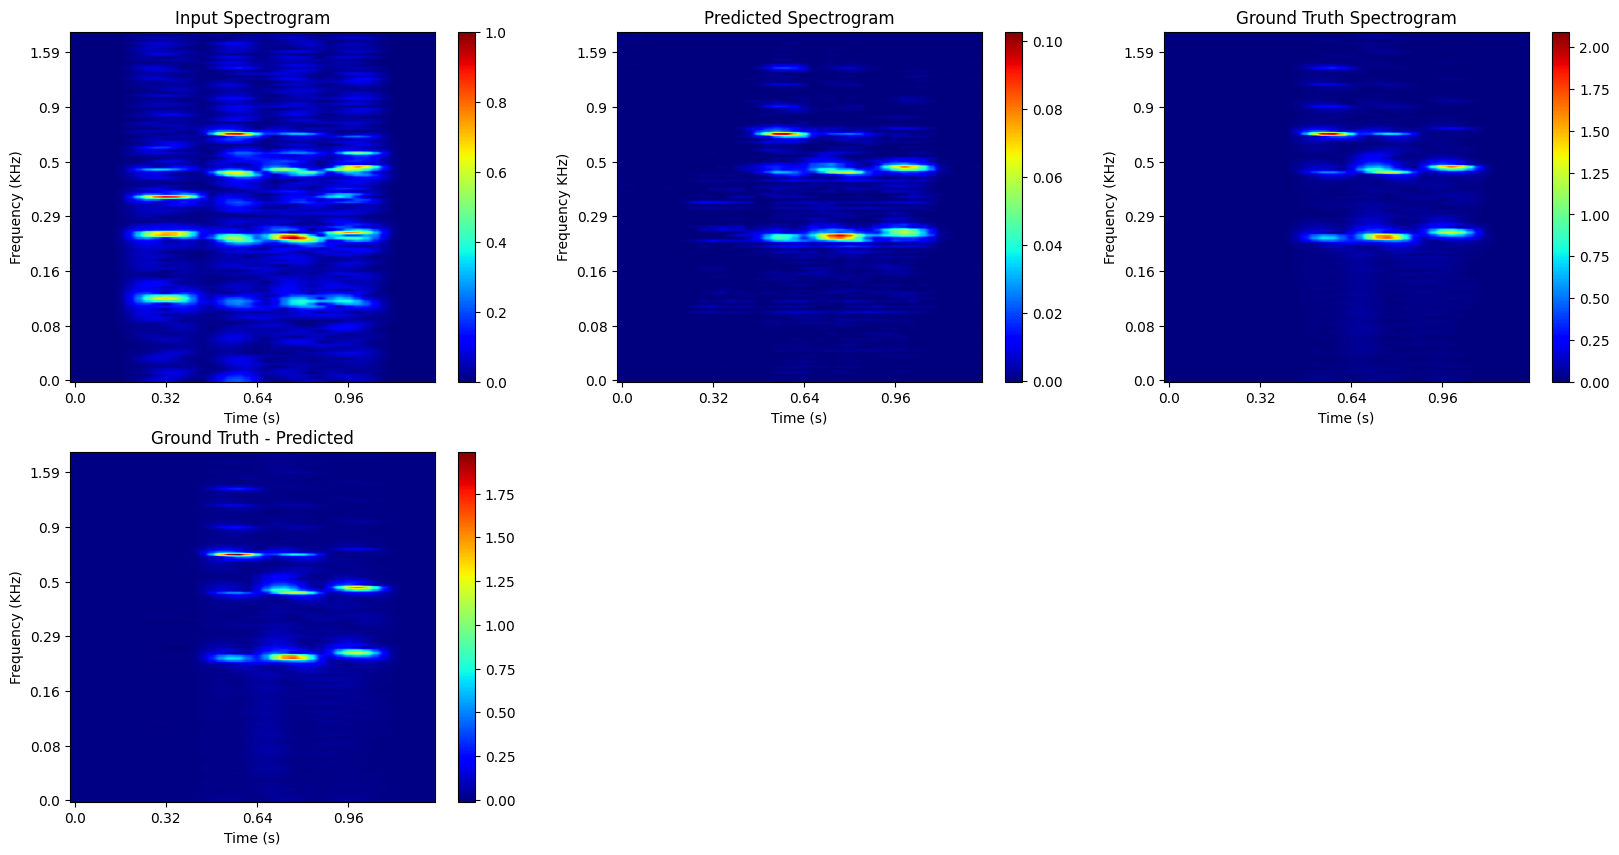

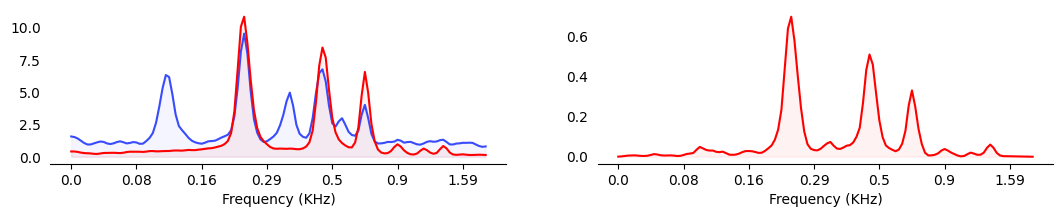

100it [00:28,  3.53it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.7
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

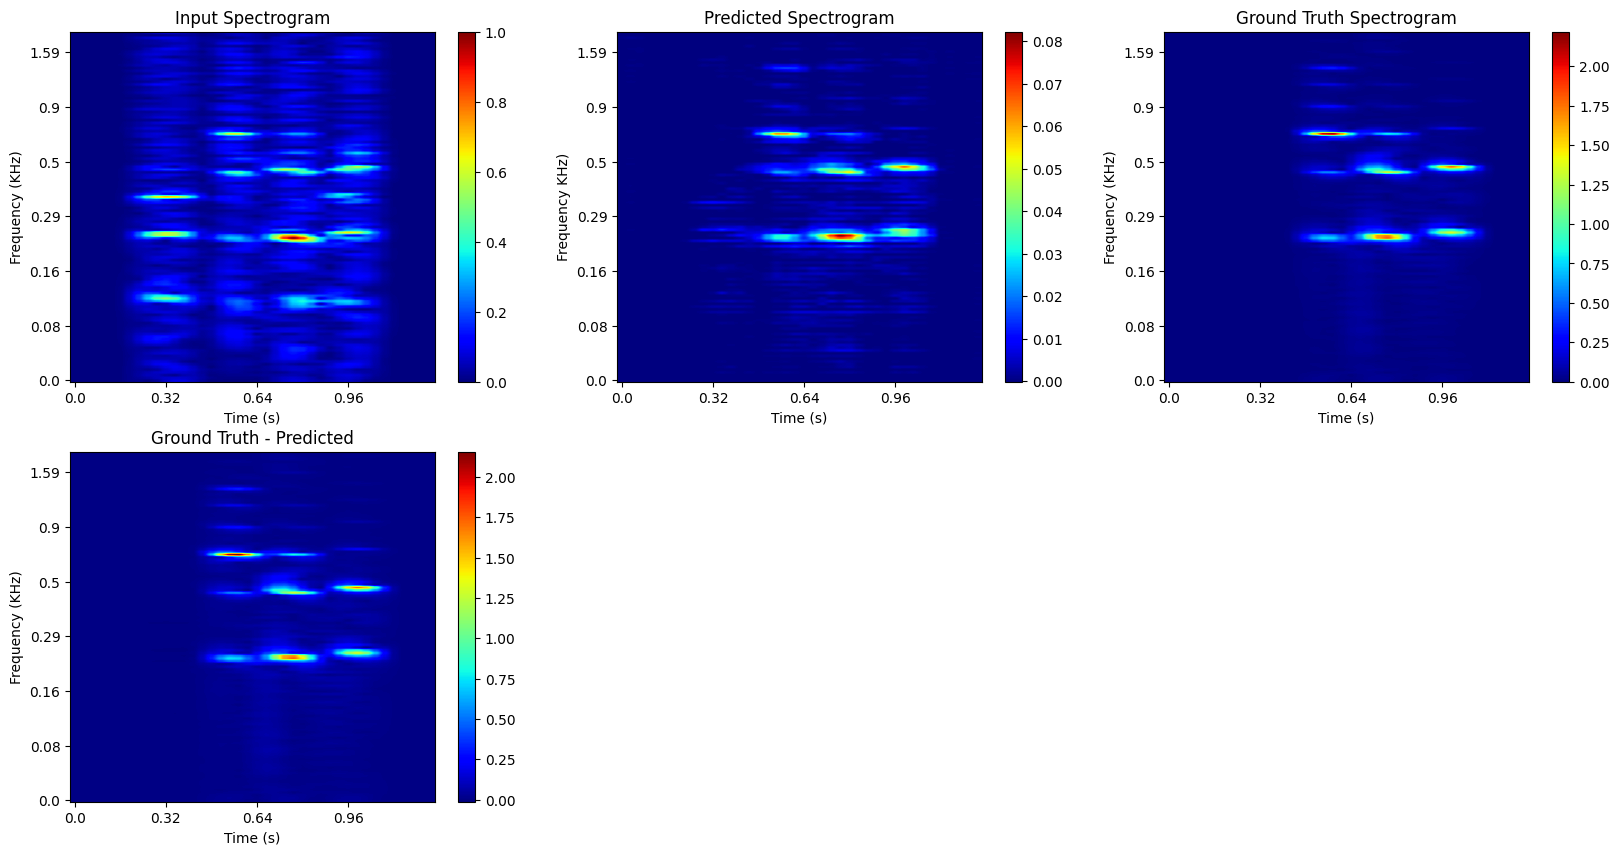

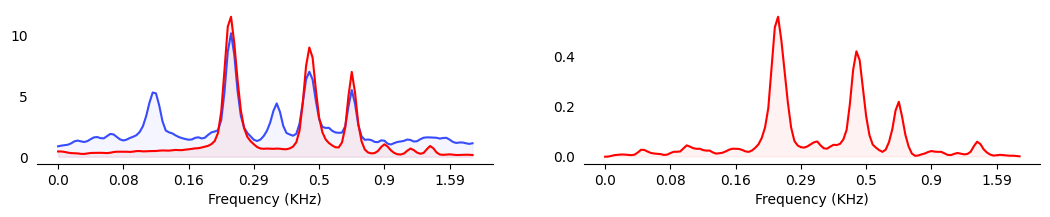

100it [00:28,  3.54it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.8
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

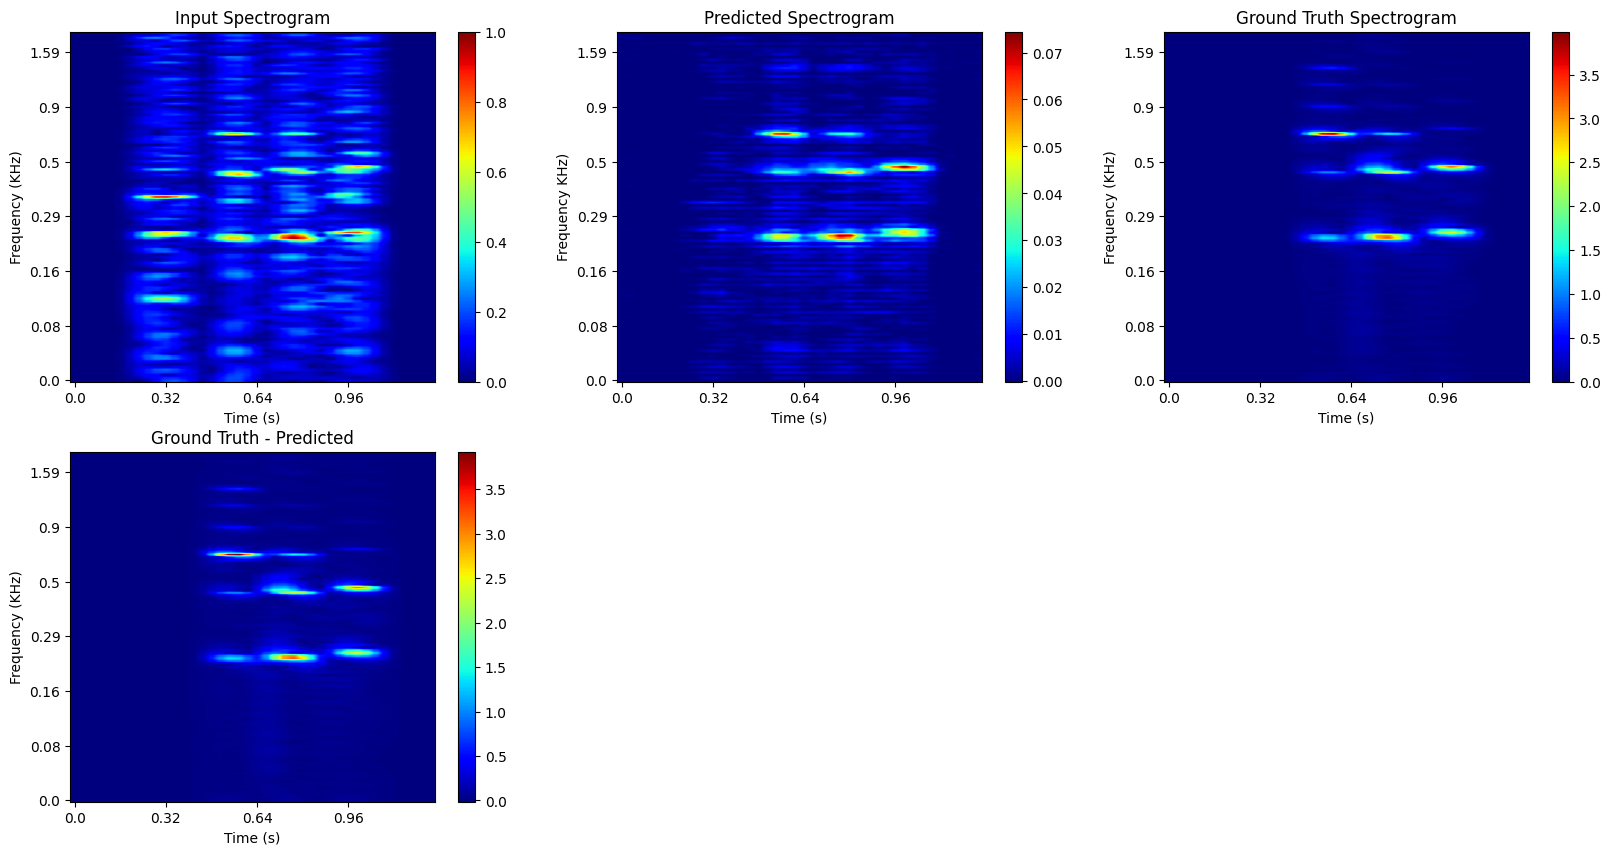

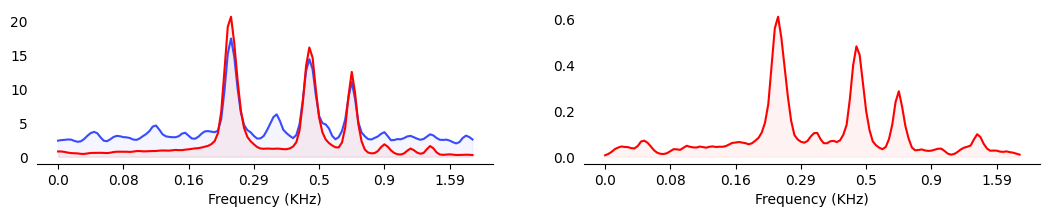

100it [00:27,  3.59it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_0.9
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

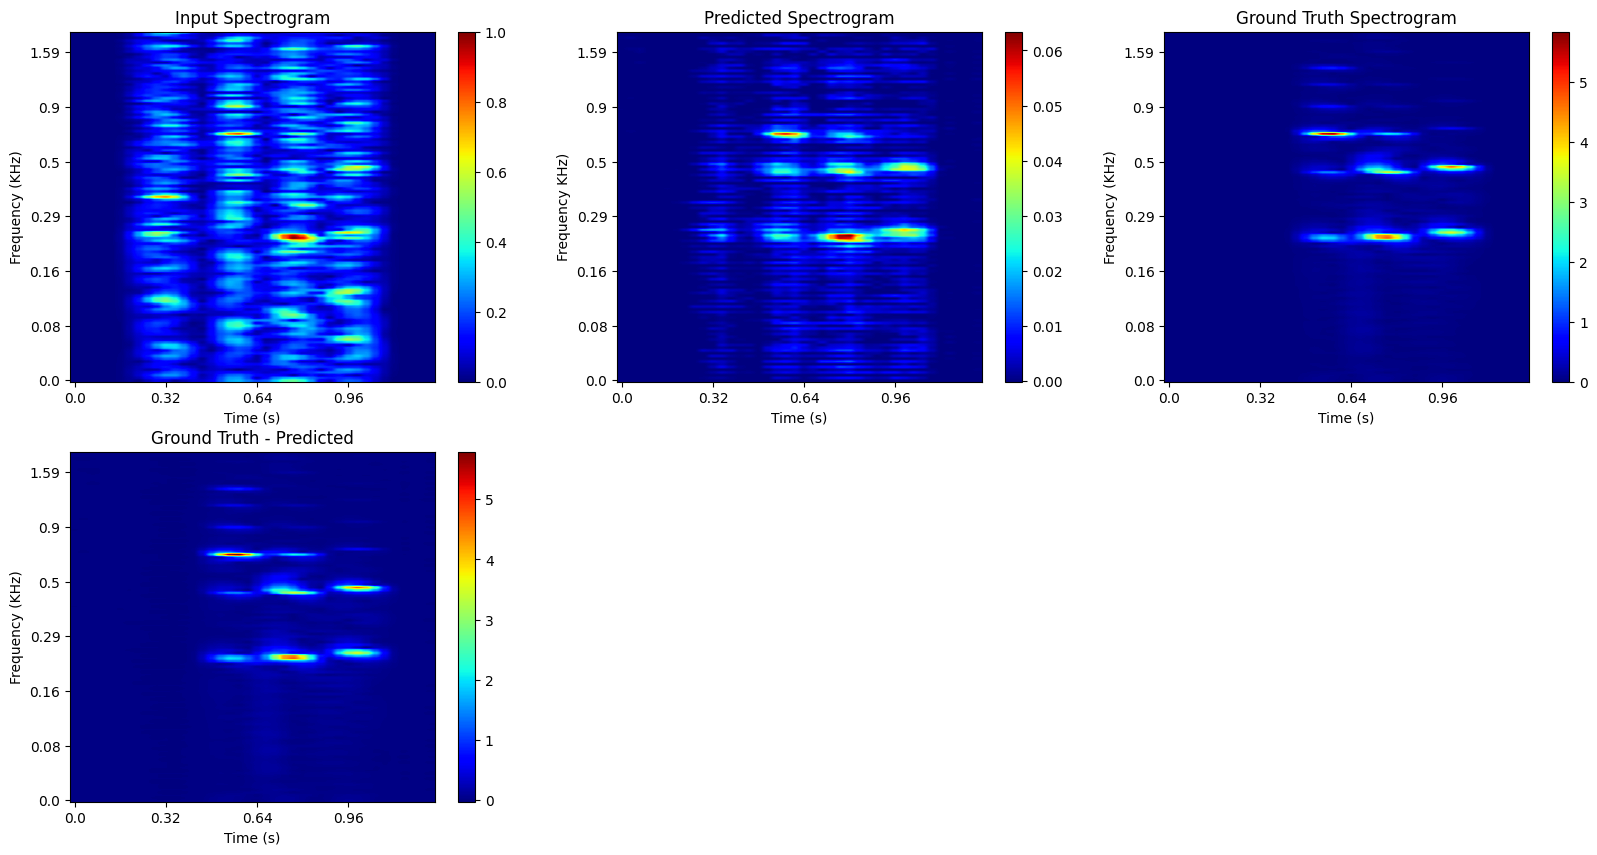

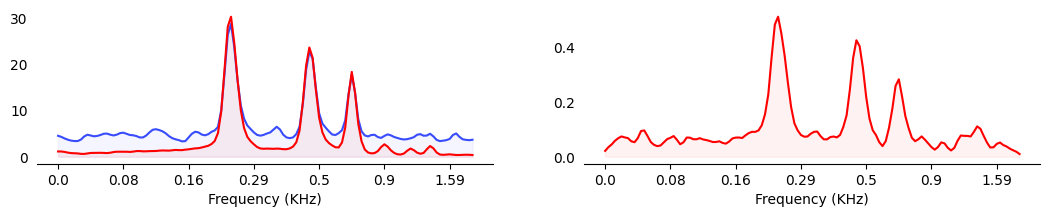

100it [00:27,  3.60it/s]


/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/jitter_1.0
Dataset Length: 100
loader complete


0it [00:00, ?it/s]

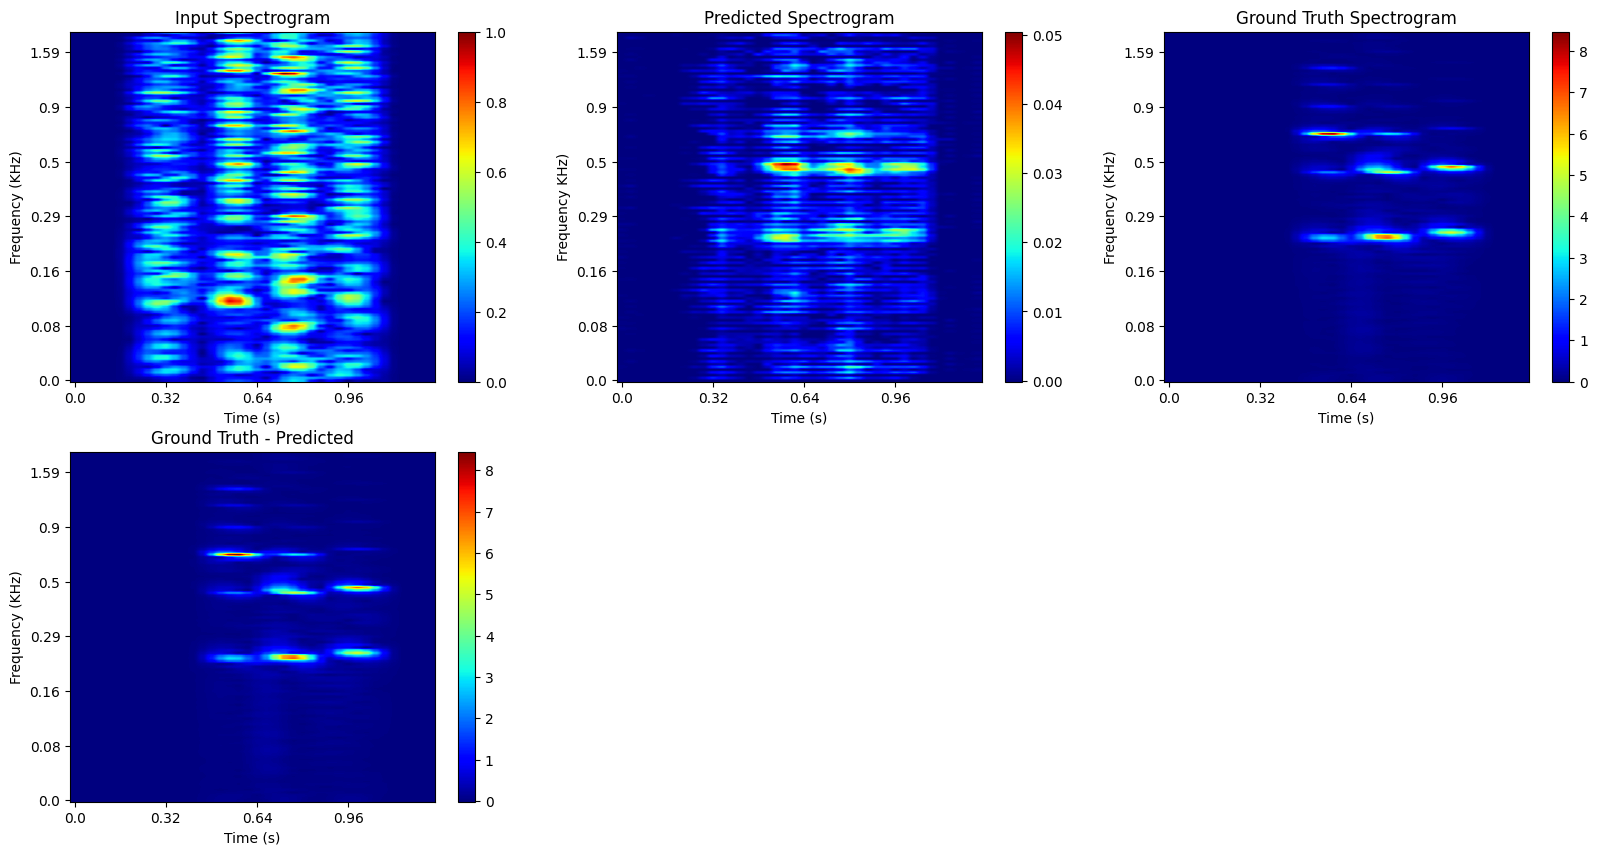

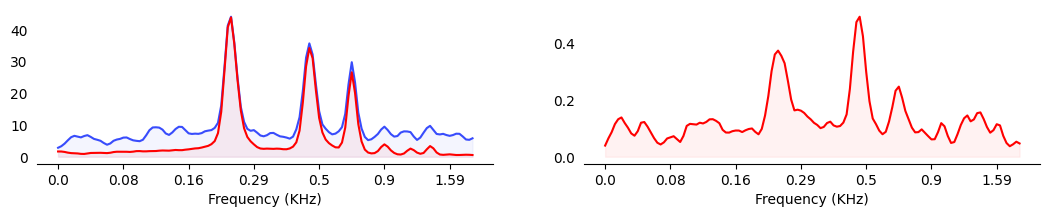

100it [00:27,  3.65it/s]


In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt

def evaluate_jitter_effects(parent_dir, jitter_levels):
    """
    Evaluate the effect of jitter on audio files by calculating average scores and standard errors for each jitter level.
    """
    means = []
    stderrs = []
    for jitter in jitter_levels:
        jitter_dir = os.path.join(parent_dir, f"jitter_{jitter}")
        #if os.path.exists(jitter_dir + "/"):
        print(jitter_dir)
        scores = get_scores(jitter_dir + "/")
        mean_score = np.mean(scores)
        stderr = np.std(scores) / np.sqrt(len(scores))  # Standard Error of the mean
        means.append(mean_score)
        stderrs.append(stderr)
    return means, stderrs

# Specify the parent directory of the jittered directories
parent_dir = "/home/karan/sda_link/datasets/Ferret_data/Dataset_2/embeddings/wavs/"  # Update this to the actual path
jitter_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Evaluate scores for each jitter directory
means, stderrs = evaluate_jitter_effects(parent_dir, jitter_levels)

# Plot the scores with error bars
#plot_scores(jitter_levels, means, stderrs)


/tmp/ipykernel_1202400/3262742659.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(jitter_levels, means, yerr=stderrs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='red', marker='o')


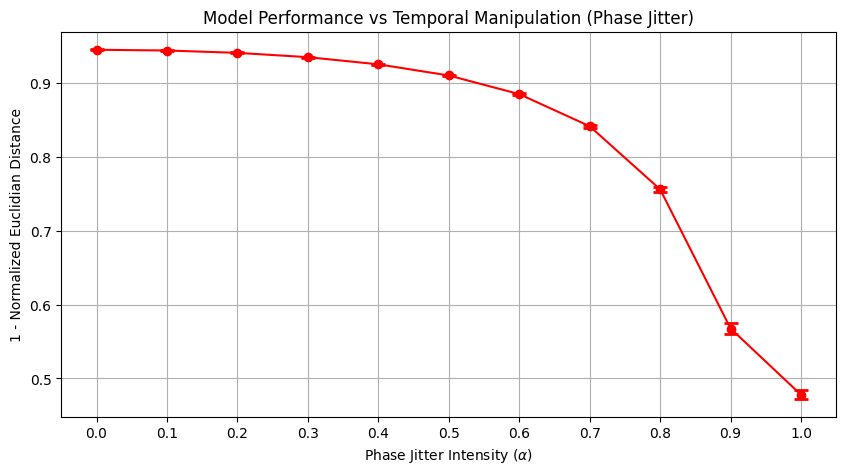

In [18]:
def plot_scores(jitter_levels, means, stderrs):
    """
    Plot jitter levels against their corresponding scores with standard error bars.
    """
    plt.figure(figsize=(10, 5))
    plt.errorbar(jitter_levels, means, yerr=stderrs, fmt='-o', capsize=5, capthick=2, ecolor='red', color='red', marker='o')
    plt.title('Model Performance vs Temporal Manipulation (Phase Jitter)')
    plt.xlabel('Phase Jitter Intensity ($\\alpha$)')
    plt.ylabel('1 - Normalized Euclidian Distance')
    plt.grid(True)
    plt.xticks(jitter_levels)
    #plt.yscale("logit")
    plt.show()

plot_scores(jitter_levels, means, stderrs)

In [12]:
import torch.nn as nn
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)